<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/online_process_simulation_demo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
! apt update -q
! apt-get install -q openjdk-25-jdk-headless -q
! pip install neqsim -q
!pip install -U pydantic

# 1. Read Eclipse E300 file

In [2]:
import os

if os.path.isfile('fluid1.e300'):
   print("Eclipse fluid file ok...")
else:
  print("Error...please provide an Eclipse fluid file...")

Eclipse fluid file ok...


# 2. Process model

In [3]:
from pydantic import Field, field_validator
from pydantic.dataclasses import dataclass
from typing import Optional, List
from neqsim import jNeqSim
from functools import cache

@dataclass
class ProcessInput():
    """
    A class to define input parameters for the oil process.
    """
    flowRateHPsep: float = Field(ge=0.0, le=100000000.0, title="Flow rate to HP separator [kg/hr]")
    flowRateLPsep: float = Field(ge=0.0, le=1000000000.0, title="Flow rate to LP separator [kg/hr]")
    firstStagePressure: float = Field(ge=0.0, le=100.0, title="Pressure of first stage separator [bara]")
    firstStageTemperature: float = Field(ge=0.0, le=100.0, title="Temperature of first stage separator [C]")
    secondStagePressure: float = Field(ge=0.0, le=100.0, title="Second stage separator pressure [bara]")
    secondStageTemperature: float = Field(ge=0.0, le=100.0, title="Second stage separator temperature [C]")
    thirdStagePressure: float = Field(ge=0.0, le=100.0, title="Third stage separator pressure [bara]")
    thirdStageTemperature: float = Field(ge=0.0, le=100.0, title="Third stage separator temperature [C]")
    fourthStagePressure: float = Field(ge=0.0, le=100.0, title="Fourth stage separator pressure [bara]")
    fourthStageTemperature: float = Field(ge=0.0, le=100.0, title="Fourth stage separator temperature [C]")
    export_oil_temperature: float = Field(ge=0.0, le=100.0, title="Export oil temperature [C]")
    export_oil_pressure: float = Field(ge=0.0, le=100.0, title="Export oil pressure [bara]")
    export_gas_pressure: float = Field(ge=0.0, le=200.0, title="Export gas pressure [bara]")
    export_gas_temperature: float = Field(ge=0.0, le=100.0, title="Export gas temperature [C]")
    gasCoolerTemperature:float = Field(ge=0.0, le=100.0, title="Gas cooler temperature [C]")

@dataclass
class ProcessOutput:
    """
    A class to define output results from an Oil process simulation.
    """
    mass_balance: Optional[float] = None
    recompressor1_power: Optional[float] = None
    recompressor2_power: Optional[float] = None
    recompressor3_power: Optional[float] = None
    exportcompressor_power: Optional[float] = None
    gasexportflow: Optional[float] = None
    oilexportflow: Optional[float] = None
    export_gas_cooler_duty: Optional[float] = None

@cache
def getprocess():
    """
    The method creates a oil process object using neqsim
    """

    wellFluid = jNeqSim.thermo.util.readwrite.EclipseFluidReadWrite.read('fluid1.e300')
    wellFluid .setMultiPhaseCheck(True)
    LPwellFLuid = wellFluid.clone()

    wellStreamHP = jNeqSim.processSimulation.processEquipment.stream.Stream(wellFluid)
    wellStreamHP.setName("HP well stream")

    LPwellStream = jNeqSim.processSimulation.processEquipment.stream.Stream(LPwellFLuid)
    LPwellStream.setName("LP well stream")

    firstStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(wellStreamHP)
    firstStageSeparator.setName("1st stage separator")

    oilHeaterFromFirstStage = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(firstStageSeparator.getOilOutStream())
    oilHeaterFromFirstStage.setName("oil heater second stage")

    secondStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(oilHeaterFromFirstStage.getOutStream())
    secondStageSeparator.addStream(LPwellStream)
    secondStageSeparator.setName("2nd stage separator")

    oilHeaterFromSecondStage = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(secondStageSeparator.getOilOutStream())
    oilHeaterFromSecondStage.setName("oil heater third stage")

    thirdStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(oilHeaterFromSecondStage.getOutStream())
    thirdStageSeparator.setName("3rd stage separator")

    oilThirdStage =  wellStreamHP.clone()
    oilThirdStage.setName("third stage oil reflux")
    oilThirdStage.setFlowRate(10.0, 'kg/hr')

    oilThirdStageMixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer()
    oilThirdStageMixer.setName("third stage oil mixer")
    oilThirdStageMixer.addStream(thirdStageSeparator.getOilOutStream())
    oilThirdStageMixer.addStream(oilThirdStage)

    oilHeaterFromThirdStage = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(oilThirdStageMixer.getOutStream())
    oilHeaterFromThirdStage.setName("oil heater fourth stage")

    fourthStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(oilHeaterFromThirdStage.getOutStream())
    fourthStageSeparator.setName("4th stage separator")

    firstStageCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(fourthStageSeparator.getGasOutStream())
    firstStageCooler.setName("1st stage cooler")

    firstStageScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(firstStageCooler.getOutStream())
    firstStageScrubber.setName("1st stage scrubber")

    firstStageCompressor = jNeqSim.processSimulation.processEquipment.compressor.Compressor(firstStageScrubber.getGasOutStream())
    firstStageCompressor.setName("1st stage compressor")
    firstStageCompressor.setUsePolytropicCalc(True)
    firstStageCompressor.setPolytropicEfficiency(0.8)

    firststagegasmixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("first stage mixer")
    firststagegasmixer.addStream(firstStageCompressor.getOutStream())
    firststagegasmixer.addStream(thirdStageSeparator.getGasOutStream())

    firstStageCooler2 = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(firststagegasmixer.getOutStream())
    firstStageCooler2.setName("1st stage cooler2")

    firstStageScrubber2 = jNeqSim.processSimulation.processEquipment.separator.Separator(firstStageCooler2.getOutStream())
    firstStageScrubber2.setName("1st stage scrubber2")

    firstStageCompressor2 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(firstStageScrubber2.getGasOutStream())
    firstStageCompressor2.setName("2nd stage compressor")
    firstStageCompressor2.setUsePolytropicCalc(True)
    firstStageCompressor2.setPolytropicEfficiency(0.8)

    secondstagegasmixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("second Stage mixer")
    secondstagegasmixer.addStream(firstStageCompressor2.getOutStream())
    secondstagegasmixer.addStream(secondStageSeparator.getGasOutStream())

    secondStageCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(secondstagegasmixer.getOutStream())
    secondStageCooler.setName("2nd stage cooler")

    secondStageScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(secondStageCooler.getOutStream())
    secondStageScrubber.setName("2nd stage scrubber")

    secondStageCompressor = jNeqSim.processSimulation.processEquipment.compressor.Compressor(secondStageScrubber.getGasOutStream())
    secondStageCompressor.setName("3rd stage compressor")
    secondStageCompressor.setUsePolytropicCalc(True)
    secondStageCompressor.setPolytropicEfficiency(0.8)

    richGasMixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("fourth Stage mixer")
    richGasMixer.addStream(secondStageCompressor.getOutStream())
    richGasMixer.addStream(firstStageSeparator.getGasOutStream())

    dewPointControlCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(richGasMixer.getOutStream())
    dewPointControlCooler.setName("dew point cooler")

    dewPointScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(dewPointControlCooler.getOutStream())
    dewPointScrubber.setName("dew point scrubber")

    lpLiqmixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("LP liq gas mixer");
    lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
    lpLiqmixer.addStream(firstStageScrubber2.getLiquidOutStream());
    lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
    lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

    lpResycle = jNeqSim.processSimulation.processEquipment.util.Recycle("LP liq resycle")
    lpResycle.addStream(lpLiqmixer.getOutStream())
    lpResycle.setOutletStream(oilThirdStage)
    lpResycle.setTolerance(1e-6)

    exportoil = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(fourthStageSeparator.getOilOutStream())
    exportoil.setName("export oil cooler")

    exportoilstream = jNeqSim.processSimulation.processEquipment.stream.Stream(exportoil.getOutStream())
    exportoilstream.setName('export oil')

    exportCompressor1 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(dewPointScrubber.getGasOutStream())
    exportCompressor1.setName("export gas compressor")
    exportCompressor1.setUsePolytropicCalc(True)
    exportCompressor1.setPolytropicEfficiency(0.8857)

    exportGasCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(exportCompressor1.getOutStream())
    exportGasCooler.setName("export gas cooler")

    exportGas = jNeqSim.processSimulation.processEquipment.stream.Stream(exportGasCooler.getOutStream())
    exportGas.setName("export gas")

    oilprocess = jNeqSim.processSimulation.processSystem.ProcessSystem()
    oilprocess.add(wellStreamHP)
    oilprocess.add(LPwellStream)
    oilprocess.add(firstStageSeparator)
    oilprocess.add(oilHeaterFromFirstStage)
    oilprocess.add(secondStageSeparator)
    oilprocess.add(oilHeaterFromSecondStage)
    oilprocess.add(thirdStageSeparator)
    oilprocess.add(oilThirdStage)
    oilprocess.add(oilThirdStageMixer)
    oilprocess.add(oilHeaterFromThirdStage)
    oilprocess.add(fourthStageSeparator)
    oilprocess.add(firstStageCooler)
    oilprocess.add(firstStageScrubber)
    oilprocess.add(firstStageCompressor)
    oilprocess.add(firststagegasmixer)
    oilprocess.add(firstStageCooler2)
    oilprocess.add(firstStageScrubber2)
    oilprocess.add(firstStageCompressor2)
    oilprocess.add(secondstagegasmixer)
    oilprocess.add(secondStageCooler)
    oilprocess.add(secondStageScrubber)
    oilprocess.add(secondStageCompressor)
    oilprocess.add(richGasMixer)
    oilprocess.add(dewPointControlCooler)
    oilprocess.add(dewPointScrubber)
    oilprocess.add(lpLiqmixer)
    oilprocess.add(lpResycle)
    oilprocess.add(exportoil)
    oilprocess.add(exportoilstream)
    oilprocess.add(exportCompressor1)
    oilprocess.add(exportGasCooler)
    oilprocess.add(exportGas)

    return oilprocess


def updateinput(process, locinput):
    """
    Update process with input parameters. Error handling added for non-existing units.
    """
    # Try accessing each unit and catch any potential AttributeError
    try:
      process.getUnit('HP well stream').setFlowRate(locinput.flowRateHPsep, 'kg/hr')
      process.getUnit('HP well stream').setTemperature(locinput.firstStageTemperature, "C")
      process.getUnit('HP well stream').setPressure(locinput.firstStagePressure, "bara")
      process.getUnit('LP well stream').setFlowRate(locinput.flowRateLPsep,'kg/hr')
      process.getUnit('LP well stream').setTemperature(locinput.secondStageTemperature, "C")
      process.getUnit('LP well stream').setPressure(locinput.secondStagePressure, "bara")
      process.getUnit('oil heater second stage').setOutTemperature(locinput.secondStageTemperature,'C')
      process.getUnit('oil heater second stage').setOutPressure(locinput.secondStagePressure,'bara')
      process.getUnit('oil heater third stage').setOutTemperature(locinput.thirdStageTemperature,'C')
      process.getUnit('oil heater third stage').setOutPressure(locinput.thirdStagePressure,'bara')
      process.getUnit('oil heater fourth stage').setOutTemperature(locinput.fourthStageTemperature,'C')
      process.getUnit('oil heater fourth stage').setOutPressure(locinput.fourthStagePressure,'bara')
      process.getUnit('export oil cooler').setOutTemperature(locinput.export_oil_temperature,'C')
      process.getUnit('export oil cooler').setOutPressure(locinput.export_oil_pressure,'bara')
      process.getUnit('1st stage cooler').setOutTemperature(locinput.gasCoolerTemperature,'C')
      process.getUnit('1st stage compressor').setOutletPressure(locinput.thirdStagePressure)
      process.getUnit('1st stage cooler2').setOutTemperature(locinput.gasCoolerTemperature,'C')
      process.getUnit('2nd stage compressor').setOutletPressure(locinput.secondStagePressure)
      process.getUnit('2nd stage cooler').setOutTemperature(locinput.gasCoolerTemperature,'C')
      process.getUnit('3rd stage compressor').setOutletPressure(locinput.firstStagePressure)
      process.getUnit('export gas compressor').setOutletPressure(locinput.export_gas_pressure, 'bara')
      process.getUnit('export gas cooler').setOutTemperature(locinput.export_gas_temperature,'C')
    except AttributeError as e:
        print(f"Failed to update unit parameters: {e}")


def getoutput(process):
    # update output
    #oilprocess.getUnit('HP well stream').getFluid().prettyPrint()
    outputparam = {
        'mass_balance': process.getUnit('HP well stream').getFlowRate('kg/hr')+process.getUnit('LP well stream').getFlowRate('kg/hr')-process.getUnit('export gas').getFlowRate('kg/hr')-process.getUnit('export oil').getFlowRate('kg/hr'),
        'recompressor1_power': process.getUnit('1st stage compressor').getPower()/1e3,
        'export_gas_cooler_duty':process.getUnit('export gas cooler').getDuty()/1e3,
        'recompressor2_power': process.getUnit('2nd stage compressor').getPower()/1e3,
        'recompressor3_power': process.getUnit('3rd stage compressor').getPower()/1e3,
        'exportcompressor_power': process.getUnit('export gas compressor').getPower()/1e3,
        'oilexportflow':process.getUnit('export oil').getFlowRate('idSm3/hr')*24.0,
        'gasexportflow':process.getUnit('export gas').getFlowRate('MSm3/day'),
    }
    return outputparam

def run_process_with_timeout(process, input_params, timeout=60, runstep=False):
    """Run the oil process calculation with a specified timeout."""
    updateinput(process=process, locinput=ProcessInput(**input_params))
    process.setRunInSteps(runstep)
    thread = process.runAsThread()
    thread.join(timeout*1000)
    if thread.isAlive():
        print('Process calculation timed out. Consider recreating the process object or adjusting parameters.')
        return None
    return ProcessOutput(**getoutput(process=process))

In [4]:
# Create oil process (only do first time)
oilprocess = getprocess()

# 3. Set input parameters and run simulations

In [5]:
inputparam = {
    'flowRateHPsep': 1000000.0,
    'flowRateLPsep': 300000.0,
    'firstStagePressure': 65.0,
    'firstStageTemperature': 85.0,
    'secondStagePressure': 22.0,
    'secondStageTemperature': 65.0,
    'thirdStagePressure': 4.5,
    'thirdStageTemperature': 63.5,
    'fourthStagePressure': 1.7,
    'fourthStageTemperature': 63.0,
    'export_oil_temperature': 20.0,
    'export_oil_pressure': 20.8,
    'export_gas_pressure': 126.5,
    'export_gas_temperature': 55.0,
    'gasCoolerTemperature': 25.0
}

# Update input parameters for process calculations.
# Note: In case of a process crash, the `oilprocess` object should be recreated to ensure stability for subsequent runs.
# Reusing the `oilprocess` object without unnecessary recreation can enhance numerical performance,
# as new calculations can leverage the solutions from previous runs. However, ensure to manage this carefully to avoid state-related errors.
# The `getprocess()` function is tasked with either creating a new `oilprocess` object or fetching an existing one,
# depending on the design to balance between computational efficiency and error resilience.

runstep=False

#timout parameter has unit seconds
results = run_process_with_timeout(process=oilprocess, input_params=inputparam, timeout=60,runstep=runstep)
if results and (results.mass_balance > 0.5 and runstep==False):
    print('Calculation failed to converge. Recreating process object...')
    print('Mass balance: ' , results.mass_balance, ' %')
    oilprocess = getprocess()
else:
    print('Calculation successful. Results: %s', results.__dict__ if results else 'No results')

Calculation successful. Results: %s {'mass_balance': 0.04321766062639654, 'recompressor1_power': 118.65480989452183, 'recompressor2_power': 964.9700505775024, 'recompressor3_power': 3557.7022617369566, 'exportcompressor_power': 6644.004455087077, 'gasexportflow': 5.91141487915347, 'oilexportflow': 32553.6994817719, 'export_gas_cooler_duty': -16149.443558661655}


# We start by creating a time series of input parameters

The flow rate is constant for the first 5 steps. Increase Phase: The flow rate increases by a total of 20% over the next 10 steps. Decrease Phase: The flow rate goes back to the original value over another 10 steps.

Final Constant Phase: The flow rate is constant again for the final 5 steps.
Given the starting flow rate of X, a 20% increase over 10 steps results in an increment of 2% per step. Let's generate the structures accordingly. Here's how to calculate it:

In [6]:
# Define the starting input parameters
start_struct = {
    'flowRateHPsep': 1000000.0,
    'flowRateLPsep': 300000.0,
    'firstStagePressure': 65.0,
    'firstStageTemperature': 85.0,
    'secondStagePressure': 22.0,
    'secondStageTemperature': 65.0,
    'thirdStagePressure': 4.5,
    'thirdStageTemperature': 63.5,
    'fourthStagePressure': 1.7,
    'fourthStageTemperature': 63.0,
    'export_oil_temperature': 20.0,
    'export_oil_pressure': 20.8,
    'export_gas_pressure': 126.5,
    'export_gas_temperature': 55.0,
    'gasCoolerTemperature': 25.0
}

# Initialize list to hold all the structs
inputparam = []

# Constants
initial_flow_rate = start_struct['flowRateHPsep']
increase_step = 0.02 * initial_flow_rate  # 2% of initial
total_steps = 5 + 10 + 10 + 5  # Total steps

# Generate structs
for step in range(total_steps):
    if step < 5:
        flow_rate = initial_flow_rate
    elif step < 15:
        flow_rate = initial_flow_rate + (step - 5 + 1) * increase_step
    elif step < 25:
        flow_rate = initial_flow_rate + (10 - (step - 15)) * increase_step
    else:
        flow_rate = initial_flow_rate

    # Create a new struct with the updated flow rate
    new_struct = start_struct.copy()
    new_struct['flowRateHPsep'] = flow_rate
    inputparam.append(new_struct)

# Online simulation where model is created from scratch and solved on each time step
This method will recreate the process at each time step, and then solve it fully as stationary simulations. This is a roust method but can be slow. The mehod is well suited for being implemented in an API, since simulations are not deendent on output from previus simulation.


In [7]:
import time
import json
runstep = True
# Start the timer
start_time = time.time()

runstep = False

results = []
for param in inputparam:  # param is each dictionary in the inputparam list
    # Assuming oilprocess and runstep are defined elsewhere in your code
    oilprocess = getprocess()
    result = run_process_with_timeout(process=oilprocess, input_params=param, timeout=60,runstep=runstep)
    json_out = str(oilprocess.getReport_json())
    json_object = json.loads(json_out)
    for key, value in json_object.items():
        json_object[key] = json.loads(value)
    results.append(json_object)
    if result and (result.mass_balance > 0.5 and not runstep):
        print('Calculation failed to converge.')
        print('Mass balance:', result.mass_balance, '%')
    else:
        if result:
            print('Calculation successful. Results:', result)  # Assuming result can be directly printed
        else:
            print('No results')


# Stop the timer
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
print('Total calculation time: {:.2f} seconds'.format(total_time))

Calculation successful. Results: ProcessOutput(mass_balance=3.634137101471424e-05, recompressor1_power=118.65481295372004, recompressor2_power=964.9700552552035, recompressor3_power=3557.702264041255, exportcompressor_power=6644.004456442356, gasexportflow=5.911414880936977, oilexportflow=32553.700968421756, export_gas_cooler_duty=-16149.443565929443)
Calculation successful. Results: ProcessOutput(mass_balance=1.2512318789958954e-06, recompressor1_power=118.6548130380801, recompressor2_power=964.9700553841551, recompressor3_power=3557.7022641047843, exportcompressor_power=6644.004456479639, gasexportflow=5.9114148809861575, oilexportflow=32553.700969520527, export_gas_cooler_duty=-16149.443566129803)
Calculation successful. Results: ProcessOutput(mass_balance=2.8335489332675934e-07, recompressor1_power=118.65481304041013, recompressor2_power=964.9700553877233, recompressor3_power=3557.7022641064214, exportcompressor_power=6644.004456480482, gasexportflow=5.911414880987514, oilexportflo

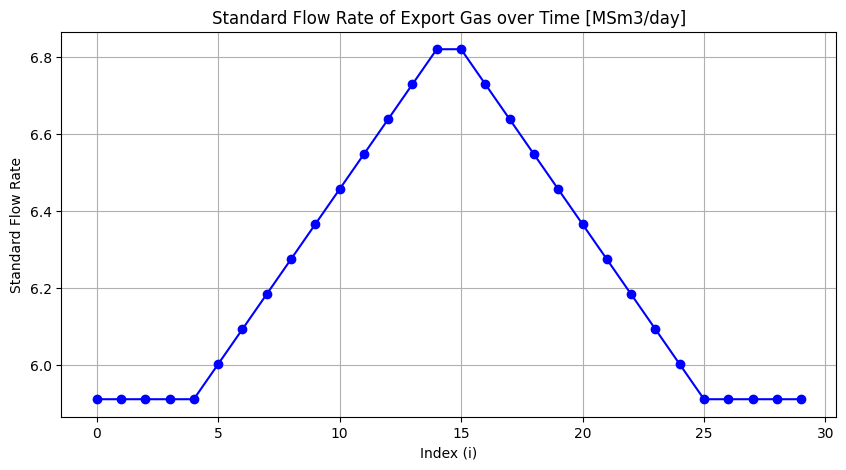

In [8]:
import matplotlib.pyplot as plt

# Extract the 'standard flow rate' from each result if available
flow_rates = []
for result in results:
    try:
        # Navigate through the dictionary according to your structure
        flow_rate = result['export gas']['properties']['gas']['standard flow rate']
        flow_rates.append(float(flow_rate['value'])/1e6*24)
    except KeyError:
        # Handle the case where the key might not exist
        flow_rates.append(None)  # Appending None or could use a placeholder like 0

# Plotting the results
plt.figure(figsize=(10, 5))  # Set the figure size as needed
plt.plot(flow_rates, marker='o', linestyle='-', color='b')  # Customize the plot with markers and line style
plt.title('Standard Flow Rate of Export Gas over Time [MSm3/day]')
plt.xlabel('Index (i)')
plt.ylabel('Standard Flow Rate')
plt.grid(True)
plt.show()

# Online simulation where each time step is fully solved
In the first method, we build upon the previous solution by running a simulation where each step involves running to full convergence. This means that all recycles are fully solved, resulting in relatively time-intensive calculations, especially when input changes significantly. If the calculation fails, a new gas process simulation object is created.

In [9]:
import time
import json
runstep = True
# Start the timer
start_time = time.time()

runstep = False

results = []
for param in inputparam:  # param is each dictionary in the inputparam list
    # Assuming oilprocess and runstep are defined elsewhere in your code
    result = run_process_with_timeout(process=oilprocess, input_params=param, timeout=60,runstep=runstep)
    json_out = str(oilprocess.getReport_json())
    json_object = json.loads(json_out)
    for key, value in json_object.items():
        json_object[key] = json.loads(value)
    results.append(json_object)
    if result and (result.mass_balance > 0.5 and not runstep):
        print('Calculation failed to converge. Recreating process object...')
        print('Mass balance:', result.mass_balance, '%')
        oilprocess = getprocess()  # Assuming get_process() is correctly defined elsewhere
    else:
        if result:
            print('Calculation successful. Results:', result)  # Assuming result can be directly printed
        else:
            print('No results')


# Stop the timer
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
print('Total calculation time: {:.2f} seconds'.format(total_time))

Calculation successful. Results: ProcessOutput(mass_balance=2.551823854446411e-07, recompressor1_power=118.65481304047243, recompressor2_power=964.9700553878263, recompressor3_power=3557.70226410655, exportcompressor_power=6644.004456480675, gasexportflow=5.911414880987555, oilexportflow=32553.700969551704, export_gas_cooler_duty=-16149.443566135435)
Calculation successful. Results: ProcessOutput(mass_balance=2.551823854446411e-07, recompressor1_power=118.65481304047088, recompressor2_power=964.9700553878328, recompressor3_power=3557.7022641065446, exportcompressor_power=6644.0044564806185, gasexportflow=5.911414880987553, oilexportflow=32553.700969551697, export_gas_cooler_duty=-16149.443566135364)
Calculation successful. Results: ProcessOutput(mass_balance=2.5564804673194885e-07, recompressor1_power=118.65481304047219, recompressor2_power=964.9700553878394, recompressor3_power=3557.7022641065437, exportcompressor_power=6644.0044564804675, gasexportflow=5.911414880987555, oilexportflo

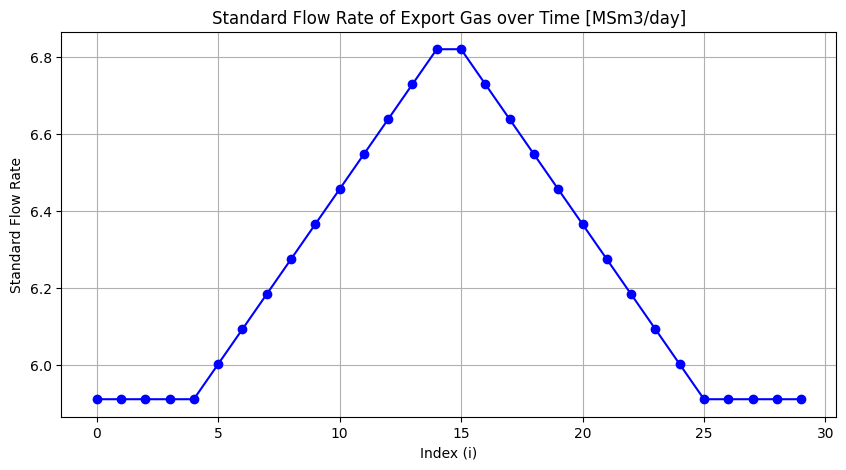

In [10]:
import matplotlib.pyplot as plt

# Extract the 'standard flow rate' from each result if available
flow_rates = []
for result in results:
    try:
        # Navigate through the dictionary according to your structure
        flow_rate = result['export gas']['properties']['gas']['standard flow rate']
        flow_rates.append(float(flow_rate['value'])/1e6*24)
    except KeyError:
        # Handle the case where the key might not exist
        flow_rates.append(None)  # Appending None or could use a placeholder like 0

# Plotting the results
plt.figure(figsize=(10, 5))  # Set the figure size as needed
plt.plot(flow_rates, marker='o', linestyle='-', color='b')  # Customize the plot with markers and line style
plt.title('Standard Flow Rate of Export Gas over Time [MSm3/day]')
plt.xlabel('Index (i)')
plt.ylabel('Standard Flow Rate')
plt.grid(True)
plt.show()

# Online simulation where process is solved in steps (not converging recycles for each time step)
In the seccond method we will run a simulation where each simulation is run but recycles are not solved. This will improve speed of calculations significantly and accuracy of calculation will in most cases be acceptable.

In [11]:
import time
import json

#timout parameter has unit seconds
# Start the timer
start_time = time.time()

runstep = True

results = []
for param in inputparam:  # param is each dictionary in the inputparam list
    # Assuming oilprocess and runstep are defined elsewhere in your code
    result = run_process_with_timeout(process=oilprocess, input_params=param, timeout=60,runstep=runstep)
    json_out = str(oilprocess.getReport_json())
    json_object = json.loads(json_out)
    for key, value in json_object.items():
        json_object[key] = json.loads(value)
    results.append(json_object)
    print('Results:', result)

# Stop the timer
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
print('Total calculation time: {:.2f} seconds'.format(total_time))

Results: ProcessOutput(mass_balance=2.544838935136795e-07, recompressor1_power=118.65481304047732, recompressor2_power=964.970055387822, recompressor3_power=3557.7022641064586, exportcompressor_power=6644.004456480691, gasexportflow=5.911414880987555, oilexportflow=32553.700969551723, export_gas_cooler_duty=-16149.443566135345)
Results: ProcessOutput(mass_balance=2.547167241573334e-07, recompressor1_power=118.65481304047559, recompressor2_power=964.9700553878257, recompressor3_power=3557.7022641065428, exportcompressor_power=6644.004456480476, gasexportflow=5.911414880987553, oilexportflow=32553.70096955172, export_gas_cooler_duty=-16149.443566135224)
Results: ProcessOutput(mass_balance=2.547167241573334e-07, recompressor1_power=118.65481304047788, recompressor2_power=964.9700553878473, recompressor3_power=3557.7022641067297, exportcompressor_power=6644.004456480944, gasexportflow=5.911414880987553, oilexportflow=32553.70096955172, export_gas_cooler_duty=-16149.443566135873)
Results: P

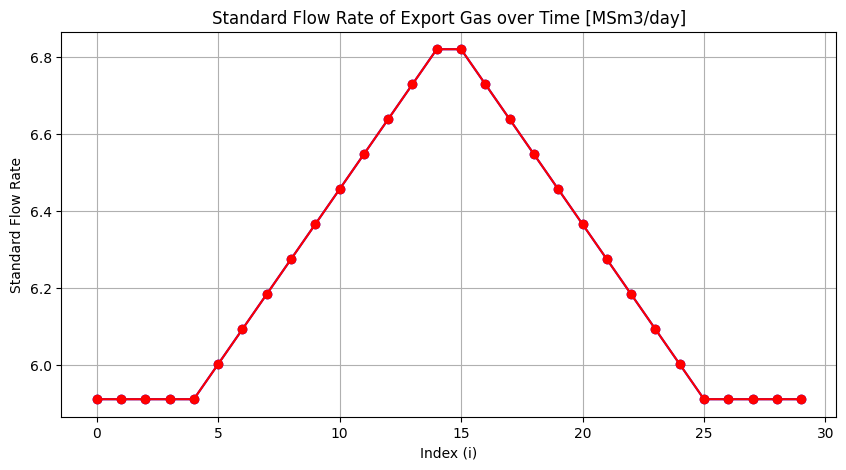

In [12]:
import matplotlib.pyplot as plt

# Extract the 'standard flow rate' from each result if available
flow_rates2 = []
for result in results:
    try:
        # Navigate through the dictionary according to your structure
        flow_rate = result['export gas']['properties']['gas']['standard flow rate']
        flow_rates2.append(float(flow_rate['value'])/1e6*24)
    except KeyError:
        # Handle the case where the key might not exist
        flow_rates2.append(None)  # Appending None or could use a placeholder like 0

# Plotting the results
plt.figure(figsize=(10, 5))  # Set the figure size as needed
plt.plot(flow_rates, marker='o', linestyle='-', color='b')  # Customize the plot with markers and line style
plt.plot(flow_rates2, marker='o', linestyle='-', color='r')  # Customize the plot with markers and line style
plt.title('Standard Flow Rate of Export Gas over Time [MSm3/day]')
plt.xlabel('Index (i)')
plt.ylabel('Standard Flow Rate')
plt.grid(True)
plt.show()

In [13]:
result['export gas']

{'name': 'export gas',
 'properties': {'gas': {'relative density': {'value': '6.839493574231441E-4',
    'unit': '[-]'},
   'molar mass': {'value': '0.019768244890944635', 'unit': 'kg/mol'},
   'WI': {'value': '52.634133567790435', 'unit': 'MJ/Sm3 @15C,15C'},
   'density': {'value': '112.05604707887231', 'unit': 'kg/m3'},
   'standard flow rate': {'value': '246308.95337585374', 'unit': 'Sm3/hr'},
   'GCV': {'value': '43.529076276376244', 'unit': 'MJ/Sm3 @15C,15C'},
   'flow rate': {'value': '1837.7094293311075', 'unit': 'm3/hr'}},
  'export gas': {'molar mass': {'value': '0.019768244890944635',
    'unit': 'kg/mol'},
   'density': {'value': '112.05604707887231', 'unit': 'kg/m3'},
   'flow rate': {'value': '1837.7094293311075', 'unit': 'm3/hr'}}},
 'conditions': {'gas': {'temperature': {'value': '55.0', 'unit': 'C'},
   'mass flow': {'value': '205926.45433041416', 'unit': 'kg/hr'},
   'fluid model': {'value': 'PR78-EoS', 'unit': ''},
   'pressure': {'value': '126.49999999999977', 'unit'

# 5. Read results from json output
The results from the simulations has been stored in json format, and can be accessed as illustred here.

In [19]:
#Read composition of export gas in first time step
results[0]['export gas']['composition']['gas']

{'C10-C12': {'value': '3.0022441441938903E-4', 'unit': 'mole fraction'},
 'C26-C28': {'value': '5.514163469863012E-9', 'unit': 'mole fraction'},
 'n-hexane': {'value': '0.001946826862607546', 'unit': 'mole fraction'},
 'nitrogen': {'value': '0.005352439872898675', 'unit': 'mole fraction'},
 'CO2': {'value': '0.015240086485948443', 'unit': 'mole fraction'},
 'propane': {'value': '0.03144545921956527', 'unit': 'mole fraction'},
 'i-pentane': {'value': '0.0024975660052050405', 'unit': 'mole fraction'},
 'n-pentane': {'value': '0.0029516008663139095', 'unit': 'mole fraction'},
 'C23-C25': {'value': '4.024409693106773E-8', 'unit': 'mole fraction'},
 'C29-C33': {'value': '8.239851970743377E-10', 'unit': 'mole fraction'},
 'n-butane': {'value': '0.010033527858110541', 'unit': 'mole fraction'},
 'i-butane': {'value': '0.004630857531699455', 'unit': 'mole fraction'},
 'C34-C80 ': {'value': '1.0362813893155561E-12', 'unit': 'mole fraction'},
 'ethane': {'value': '0.06547568512813937', 'unit': 'm

In [20]:
results[0]['export gas']['properties']

{'gas': {'relative density': {'value': '6.8394935741966E-4', 'unit': '[-]'},
  'molar mass': {'value': '0.019768244890844926', 'unit': 'kg/mol'},
  'WI': {'value': '52.634133567679726', 'unit': 'MJ/Sm3 @15C,15C'},
  'density': {'value': '112.05604707796792', 'unit': 'kg/m3'},
  'standard flow rate': {'value': '246308.95337448147', 'unit': 'Sm3/hr'},
  'GCV': {'value': '43.529076276173804', 'unit': 'MJ/Sm3 @15C,15C'},
  'flow rate': {'value': '1837.709429326432', 'unit': 'm3/hr'}},
 'export gas': {'molar mass': {'value': '0.019768244890844926',
   'unit': 'kg/mol'},
  'density': {'value': '112.05604707796792', 'unit': 'kg/m3'},
  'flow rate': {'value': '1837.7094293264322', 'unit': 'm3/hr'}}}

In [21]:
results[0]['export gas']['conditions']

{'gas': {'temperature': {'value': '55.0', 'unit': 'C'},
  'mass flow': {'value': '205926.45432822825', 'unit': 'kg/hr'},
  'fluid model': {'value': 'PR78-EoS', 'unit': ''},
  'pressure': {'value': '126.49999999999977', 'unit': 'bara'},
  'molar flow': {'value': '1.0417032744449506E7', 'unit': 'mole/hr'},
  'enthalpy': {'value': '-20328.955485134255', 'unit': 'J/kg'}},
 'export gas': {'temperature': {'value': '55.0', 'unit': 'C'},
  'mass flow': {'value': '205926.45432822825', 'unit': 'kg/hr'},
  'fluid model': {'value': 'PR78-EoS', 'unit': ''},
  'pressure': {'value': '126.49999999999977', 'unit': 'bara'},
  'molar flow': {'value': '1.0417032744449506E7', 'unit': 'mole/hr'},
  'enthalpy': {'value': '-20328.955485134255', 'unit': 'J/kg'}}}

In [22]:
results[0]['export oil']['properties']

{'oil': {'relative density': {'value': '0.845895096180149', 'unit': '-'},
  'molar mass': {'value': '0.21030296921731312', 'unit': 'kg/mol'},
  'density': {'value': '845.895096180149', 'unit': 'kg/m3'},
  'flow rate': {'value': '1293.3915217289707', 'unit': 'm3/hr'},
  'RVP': {'value': '0.44691081431342844', 'unit': 'bara'},
  'TVP': {'value': '1.201414310981023', 'unit': 'bara'}},
 'export oil': {'molar mass': {'value': '0.21030296921731312',
   'unit': 'kg/mol'},
  'density': {'value': '845.895096180149', 'unit': 'kg/m3'},
  'flow rate': {'value': '1293.3915217289707', 'unit': 'm3/hr'}}}